In [1218]:
import glob
from netCDF4 import Dataset
from dateutil.parser import parse
import datetime
import numpy as np
import matplotlib.dates as mdates
import pytz
from datetime import datetime as dt
from matplotlib import pyplot as plt

In [1219]:
the_file='cabauw_ubc_jan.nc'
group='m201401'
with Dataset(the_file,'r') as nc_ubc:
    jan_nc=nc_ubc.groups[group]
    z=nc_ubc.variables['z'][...]
    jan_speed=july_nc.variables['F'][...]
    jan_ta002 = july_nc.variables['TA002']


In [1220]:
hourly_wind_avg=jan_speed.mean(axis=2)

In [1221]:
hourly_wind_avg.shape

(31, 24, 7)

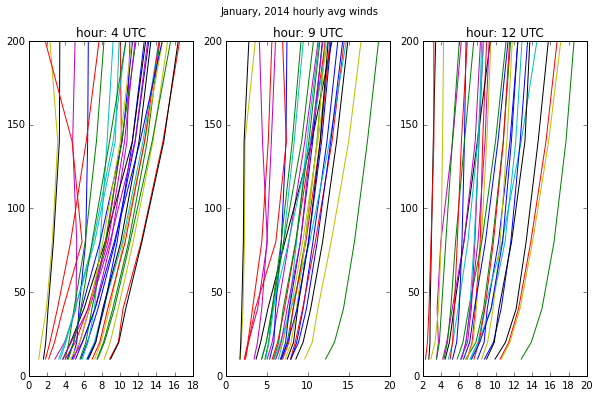

In [1222]:
%matplotlib inline
the_month='January, 2014'
hour=4
fig,ax=plt.subplots(1,3,figsize=(10,6))
ax[0].plot(hourly_wind_avg[:,hour,:].T,z)
ax[0].set(title='hour: {} UTC'.format(hour))
hour=9
ax[1].plot(hourly_wind_avg[:,hour,:].T,z)
ax[1].set(title='hour: {} UTC'.format(hour))
hour=12
ax[2].plot(hourly_wind_avg[:,hour,:].T,z)
ax[2].set(title='hour: {} UTC'.format(hour))
fig.suptitle('{} hourly avg winds'.format(the_month))

```
S=a0 + a1*z + a2*z**2 + a3*np.log(z)
direc=b0 + b1*z + b2*z**2
theta=c0 + c1*z + c2*z**2. + c3*np.log(z)
```

## Fit Function

In [1223]:


def Fit(z,hourly_wind_avg,day,hour):
    rev_z=z[::-1]
    rev_z=rev_z[1:]
    test=hourly_wind_avg[day,hour,::-1]
    test=test[1:]


    def wind_func(z, *coeffs):
        'nonlinear function in a and to fit to data'
        fit = coeffs[0] + coeffs[1]*z + coeffs[2]*z**2. + coeffs[3]*np.log(z)
        return fit

    initial_guess=[0,0,0,0]
    pars, pcov = curve_fit(wind_func, rev_z, test, p0=initial_guess)
    initial_guess
    pars
    zinterp=np.linspace(10.,200,50.)
    speed_interp=wind_func(zinterp,*pars)
    pars
    return (speed_interp,zinterp,pars)



In [1224]:
with Dataset(the_file,'r') as nc_ubc:
    jan_nc=nc_ubc.groups[group]
    HE=jan_nc.variables['H'][...]
    LE = jan_nc.variables['LE'][...]
    USTAR = jan_nc.variables['UST'][...]
    TA002 = jan_nc.variables['TA002'][...]
    Q002 = jan_nc.variables['Q002'][...]
    P0 = jan_nc.variables['P0'][...]
    timevec = jan_nc.variables['time'][...]
    timevec = [dt.fromtimestamp(item,pytz.utc) \
               for item in timevec.flat]
    
Rd=287.  #J/kg/K
cp = 1004.  #J/kg/K
k = 0.4
g=9.8
rho = P0*1.e2/(Rd*(TA002 + 273.15))

In [1225]:
def Calc_L(H,LE,TA002,Q002,USTAR):
    # 10 min L
    #fleagle and bussinger eq. 6.31
    Eb = H + 0.02*LE
    #virtural temperature 
    Tv = TA002 + 273.15  + 0.61*Q002*1.e-3
    #Fleagle and Businger 6.47
    L10 = - Tv*cp*rho*USTAR**3./(k*g*Eb)
    # Hourly L
    Eb = H.mean(axis=2)+ 0.02*LE.mean(axis=2)
    Tv = TA002.mean(axis=2) + 273.15  + 0.61*Q002.mean(axis=2)*1.e-3
    rhO = rho.mean(axis=2)
    USt=USTAR.mean(axis=2)
    LHR = - Tv*cp*rhO*USt**3./(k*g*Eb)
    return (L10,LHR)
    

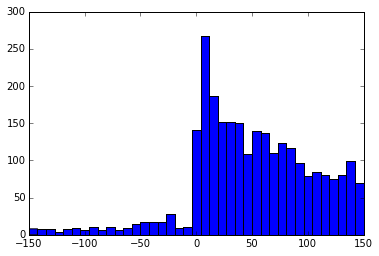

In [1226]:
L10,LHR = Calc_L(HE,LE,TA002,Q002,USTAR)
fig,ax=plt.subplots(1,1)
out=plt.hist(L.flat,bins=np.linspace(-150,150,40))

# Verkaik & Hotlslag

In [1227]:
def VKH (H,Coefs,Ust):
    D_U_z=Coefs[1]+ 2*Coefs[2]*H+Coefs[3]/H
    Phi_m = k*H*D_U_z/Ust
    return (Phi_m)

# Dyer

In [1228]:
def Dyer (zinterp,L):
    if L < 0:
        Phi_m = (1 - 16*zinterp/L)**-.25
    else:
        Phi_m = (1 + 5*zinterp/L)
    return (Phi_m)
    

# Wind Profiles & VKH Fig 5

Hour:  4  L =  247.903
Hour:  9  L =  137.855
Hour:  13  L =  526.4


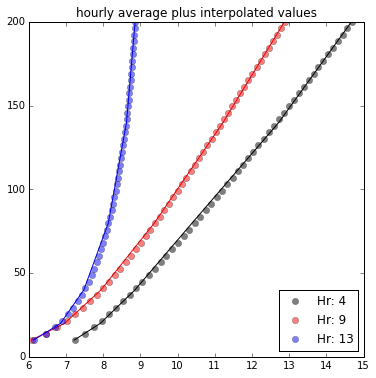

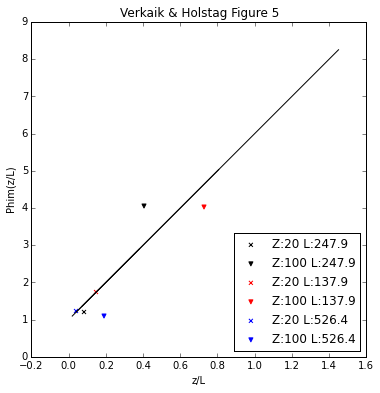

In [1250]:
#http://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/
import numpy as np
from scipy.optimize import curve_fit
import scipy
from scipy.stats.distributions import  t
import warnings
from pylab import *
rcParams['legend.numpoints'] = 1

warnings.filterwarnings("ignore",category=scipy.optimize.OptimizeWarning)

day=12
hour=4,9,13
fig,ax1=plt.subplots(1,figsize=(6,6))
color = 'black','red','blue'
ct = 0
Heights = 20,100
fig,ax2=plt.subplots(1,1,figsize=(6,6))
Ust=USTAR.mean(axis=2)
mrk = 'x','v'

for hr in hour:
    ax1.plot(hourly_wind_avg[day,hr,:],z,color = color[ct])
    speed_interp,zinterp,Coefs = Fit(z,hourly_wind_avg,day,hr)
    ax1.plot(speed_interp,zinterp,'ro',alpha=0.5,color = color[ct],label='Hr: ' + str(hr))
    Dyer_plot = Dyer(zinterp,LHR[day,hr])
    ct2 = 0
    for H in Heights:
        Phi_m = VKH(H,Coefs,Ust[day,hr])
        Zeta=H/LHR[day,hr]
        ax2.scatter(Zeta,Phi_m,color=color[ct],marker = mrk[ct2],s = 16
                    , label = 'Z:' + str(H) + ' L:'+str(np.round(LHR[day,hr],1)))
        ct2 = ct2 +1
    ax2.plot(zinterp/LHR[day,hr],Dyer_plot, color = 'black')
    print ('Hour: ', hr, ' L = ', LHR[day,hr])
    ct = ct + 1
    
ax1.set(title='hourly average plus interpolated values')
ax1.legend(loc=4)
ax2.set(title='Verkaik & Holstag Figure 5',xlabel = 'z/L',ylabel = 'Phim(z/L)')
ax2.legend(loc=4,scatterpoints=1)
        
#
# flip tower data so it goes from bottom to top
# and get rid of the lowest level, which doesn't
# have a measurement
#


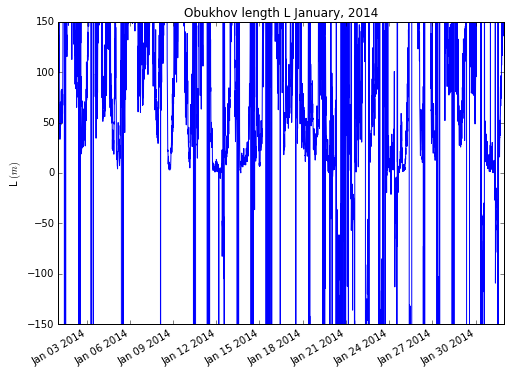

In [1230]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
fig.autofmt_xdate()
ax.plot(timevec,L.flat)
title='Obukhov length L {}'.format(the_month)
out=ax.set(title=title,ylabel='L $(m)$',ylim=[-150,150])

In [1231]:
!pwd

/home/wesley/atsc500/notebooks
